# Spoofing detection

In [15]:
import cv2
from sklearn.utils import shuffle
from os import listdir
import numpy as np
import time
import glob
#from face_detection import FaceDetection
from sklearn.decomposition import FastICA
import numpy
import PIL
from PIL import Image
#import dlib
#from imutils import face_utils
#import imutils
import os, sys
import shutil
from os import listdir
#from skimage import io
import matplotlib.pyplot as plt
import pickle 
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model
import keras

from keras import layers 
from keras import Input 
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam, RMSprop, Adadelta

sys.path.append('..')
#import face3d
#from face3d import mesh
#directory = '/home/maria/Desktop/Antispoofing_algorithm/raw' 

# TRAIN

In [16]:
#train
POS_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/train/photos/spoof'
NEG_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/train/photos/not_spoof/'
LAB_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/train/labels/not_spoof/'

pos_images = os.listdir(POS_DIR)
neg_images = os.listdir(NEG_DIR)
neg_labels = os.listdir(LAB_DIR)

In [17]:
len(pos_images), len(neg_images), len(neg_labels)

(11613, 4746, 4720)

In [18]:
#количество взятых изображений из папки train
N_IMG = 3000 #4720#2723#1283
#вход и выход нейронной сети
input_width = input_height = 256
output_width = output_height = 32 

In [19]:
# произвольный выбор изображений из папки train
select_labels = np.random.choice(neg_labels, size=N_IMG, replace=False)
select_pos = np.random.choice(pos_images, size=N_IMG, replace=False)

In [20]:
train_arrays = []
train_targets = []
train_labels = []

for lab in select_labels:
    fp = os.path.join(LAB_DIR, lab)
    with open(fp, 'rb') as f:
        depth_map = pickle.load(f)
    depth_map = Image.fromarray(depth_map)
    depth_map = depth_map.resize((output_width, output_height))
    if lab.find(str('crop'))!= -1:
        fp = os.path.join(NEG_DIR, lab[:-10] + '.jpg')
    else:
        fp = os.path.join(NEG_DIR, lab [:-4]+ '.jpg')

    img = Image.open(fp)
    img = img.resize((input_width,input_height))
    if img.size != (input_width,input_height):
        print(img.size)
    train_arrays.append(np.array(img))
    train_targets.append(np.array(depth_map))
    train_labels.append(1)

for pos in select_pos:
    fp = os.path.join(POS_DIR, pos)
    img = Image.open(fp)
    img = img.resize((input_width,input_height))
    if img.size != (input_width,input_height):
        print(img.size)
    train_arrays.append(np.array(img))
    train_targets.append(np.zeros((output_width, output_height), dtype=np.uint8))
    train_labels.append(0)

In [21]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [22]:
train_arrays = np.array(train_arrays)

In [23]:
train_targets = np.reshape(np.array(train_targets), (N_IMG*2, output_width,output_height,1))

In [24]:
train_arrays.shape

(6000, 256, 256, 3)

In [25]:
train_targets.shape

(6000, 32, 32, 1)

In [26]:
train_labels.shape

(6000, 2)

#### нормализация train

In [27]:
train_arrays = train_arrays / 255.
# train_targets = np.uint8(train_targets > 50)

##### перемешивание train

In [28]:
permute = np.random.permutation(range(train_arrays.shape[0]))
train_arrays = train_arrays[permute]
train_targets = train_targets[permute]
train_labels = train_labels[permute]

##### выведение 5 случайных пользователей из папки train

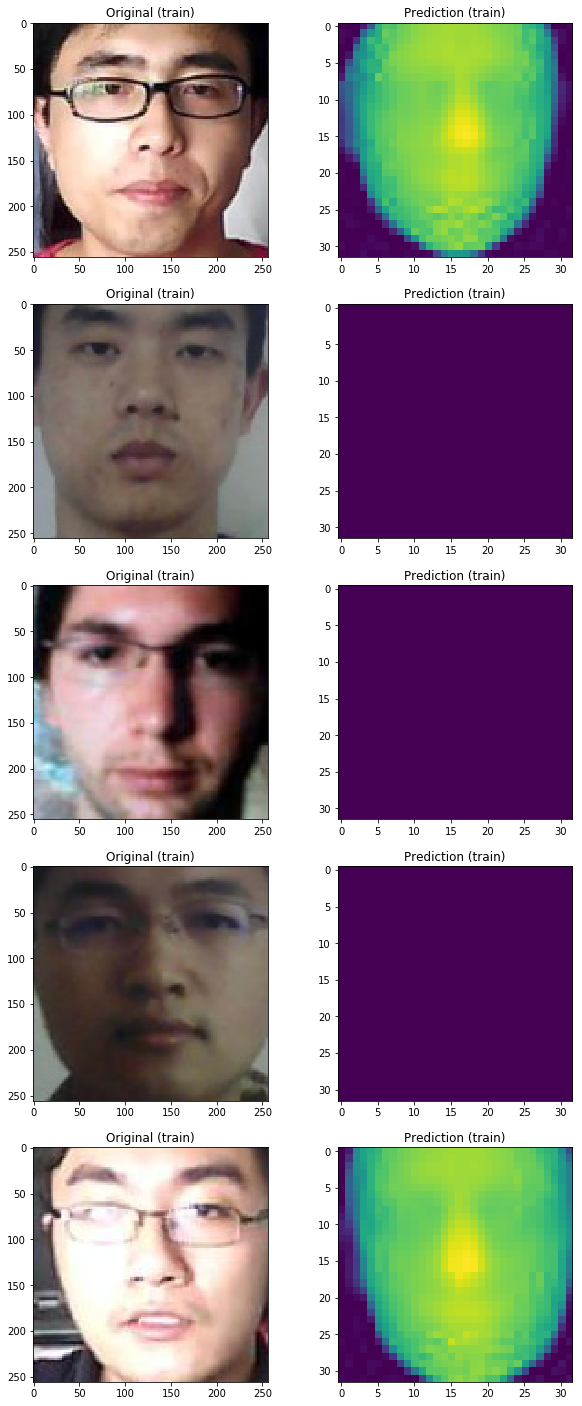

In [29]:
N_SHOW = 5
select_indices = np.random.choice(range(train_arrays.shape[0]), size=N_SHOW, replace=False)

plt.figure(figsize=(10, N_SHOW * 5))

for c,ind in enumerate(select_indices):
    plt.subplot(N_SHOW,2,c*2+1)
    plt.imshow(train_arrays[ind])
    plt.title('Original (train)')

    plt.subplot(N_SHOW,2,c*2+2)
    plt.imshow(train_targets[ind][:,:,0])
    plt.title('Prediction (train)')
plt.show()

# TEST

In [68]:
POS_TEST_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/test/photos/spoof'
NEG_TEST_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/test/photos/not_spoof/'
LAB_TEST_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/test/labels/not_spoof/'


# POS_TEST_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/train/photos/spoof'
# NEG_TEST_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/train/photos/not_spoof/'
# LAB_TEST_DIR = 'C:/Users/Maria/Desktop/Ner/New_Dataset/train/labels/not_spoof/'



In [69]:
pos_test_images = os.listdir(POS_TEST_DIR)
neg_test_images = os.listdir(NEG_TEST_DIR)
neg_test_labels = os.listdir(LAB_TEST_DIR)

In [70]:
type(pos_test_images)

list

In [71]:
len(pos_test_images), len(neg_test_images), len(neg_test_labels)

(9360, 3763, 3763)

In [72]:
N_TEST_IMG = 300#10#1845

In [73]:
select_test_labels = np.random.choice(neg_test_labels, size=N_TEST_IMG, replace=False)
select_test_pos = np.random.choice(pos_test_images, size=N_TEST_IMG, replace=False)

In [74]:
test_arrays = []
test_targets = []
test_labels = []


for lab in select_test_labels:
    fp = os.path.join(LAB_TEST_DIR, lab)
    with open(fp, 'rb') as f:
        depth_map = pickle.load(f)
    depth_map = Image.fromarray(depth_map)
    depth_map = depth_map.resize((output_width, output_height))
    if lab.find(str('crop'))!= -1:
        fp = os.path.join(NEG_TEST_DIR, lab[:-10] + '.jpg')
    else:
        fp = os.path.join(NEG_TEST_DIR, lab [:-4]+ '.jpg')
    img = Image.open(fp)
    img = img.resize((input_width,input_height))
    if img.size != (input_width,input_height):
        print(img.size)
    test_arrays.append(np.array(img))
    test_targets.append(np.array(depth_map))
    test_labels.append(1)
    
    
# for lab in select_labels:
#     fp = os.path.join(LAB_DIR, lab)
#     with open(fp, 'rb') as f:
#         depth_map = pickle.load(f)
#     depth_map = Image.fromarray(depth_map)
#     depth_map = depth_map.resize((output_width, output_height))
#     if lab.find(str('crop'))!= -1:
#         fp = os.path.join(NEG_DIR, lab[:-10] + '.jpg')
#     else:
#         fp = os.path.join(NEG_DIR, lab [:-4]+ '.jpg')

#     img = Image.open(fp)
#     img = img.resize((input_width,input_height))
#     if img.size != (input_width,input_height):
#         print(img.size)
#     train_arrays.append(np.array(img))
#     train_targets.append(np.array(depth_map))
#     train_labels.append(1)
    


for pos in select_test_pos:
    fp = os.path.join(POS_TEST_DIR, pos)
    img = Image.open(fp)
    img = img.resize((input_width,input_height))
    if img.size != (input_width,input_height):
        print(img.size)
    test_arrays.append(np.array(img))
    test_targets.append(np.zeros((output_width, output_height), dtype=np.uint8))
    test_labels.append(0)

In [75]:
from keras.utils import to_categorical
test_labels = to_categorical(test_labels)

In [79]:
test_arrays = np.array(test_arrays)
test_targets = np.reshape(np.array(test_targets), (N_TEST_IMG*2, output_width,output_height,1))

#### нормализация test

In [80]:
test_arrays = test_arrays / 255.

##### перемешивание test

In [81]:
permute = np.random.permutation(range(test_arrays.shape[0]))
test_arrays = test_arrays[permute]
test_targets = test_targets[permute]
test_labels = test_labels[permute]

##### выведение 5 случайных пользователей из папки train

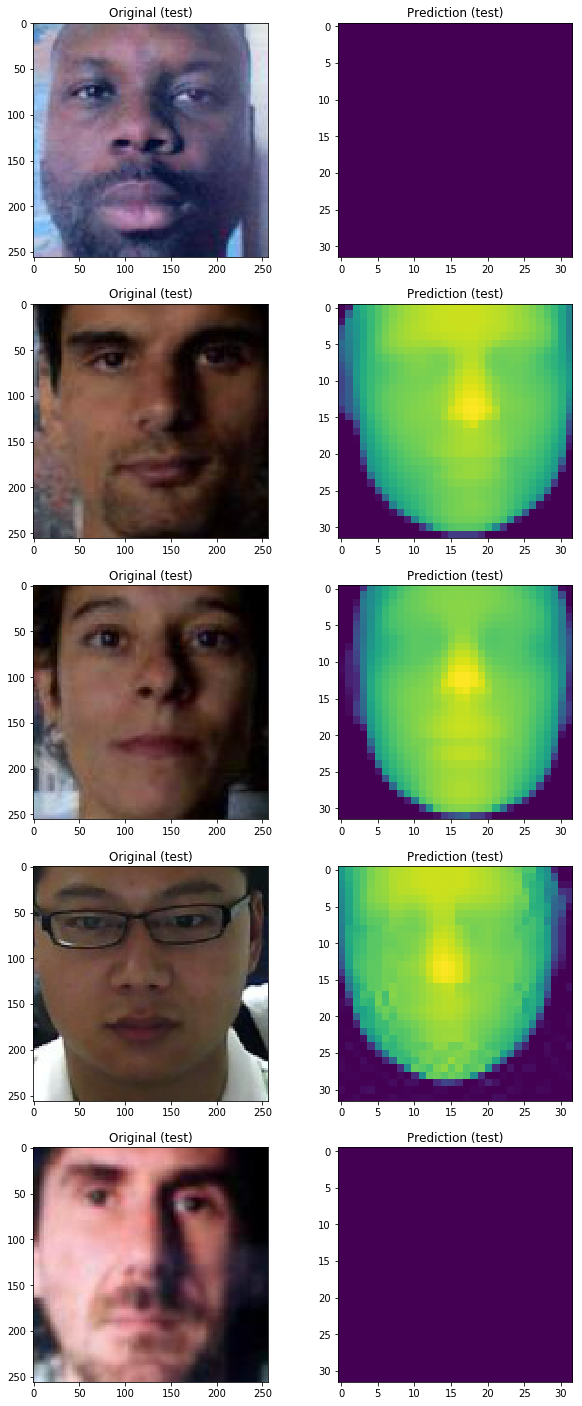

In [82]:
N_SHOW = 5
select_indices = np.random.choice(range(test_arrays.shape[0]), size=N_SHOW, replace=False)

plt.figure(figsize=(10, N_SHOW * 5))
for c,ind in enumerate(select_indices):
    plt.subplot(N_SHOW,2,c*2+1)
    plt.imshow(test_arrays[ind])
    plt.title('Original (test)')

    plt.subplot(N_SHOW,2,c*2+2)
    plt.imshow(test_targets[ind][:,:,0])
    plt.title('Prediction (test)')    
plt.show()

# Определение свёрточной сети (как в алгоритме, описанном в статье Learning Deep Models for Face Anti-spoofing: Binary or Auxiliary Supervision)

In [83]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model
import keras
from keras import layers 
from keras import Input 
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam, RMSprop, Adadelta

# Сеть для идентификации глубин

In [78]:
digit_input = Input(shape=(input_width, input_height, 3), dtype ='float32', name = 'depth_mapping')

dropout = 0.5 

x = layers.Conv2D(filters = 64, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(digit_input)
#x = layers.Dropout(dropout)(x)
x = layers.BatchNormalization()(x)

y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(x)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters= 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.MaxPooling2D((2, 2))(y)


z = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 196, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)                                                                             
z = layers.MaxPooling2D((2, 2))(z)

m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.MaxPooling2D((2, 2))(m)


# residual_1 = layers.Cropping2D(4, input_shape = (64,64,128))(y)
# residual_2 = layers.Cropping2D(2, input_shape = (32,32,128))(z)

# model.add(Cropping2D(cropping=((2, 2), (2, 2)), input_sh))
residual_2 = layers.Conv2D(128, 1, strides = 4, padding = 'same')(y)
residual_2 = layers.Dropout(dropout)(residual_2)
residual_1 = layers.Conv2D(128, 1, strides = 2, padding = 'same')(z)
residual_1 = layers.Dropout(dropout)(residual_1)


n = layers.add([residual_2, residual_1, m])

n = layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='elu', padding = 'same')(n)  
#n = layers.Dropout(dropout)(n)

n = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='elu', padding = 'same')(n) 
#n = layers.Dropout(dropout)(n)
n = layers.Conv2D(1, (1,1), activation = 'relu', padding = 'same')(n)
#n = layers.Dropout(dropout)(n)


model_for_depth = Model(digit_input, n)

# For a mean squared error regression problem
optimizer = Adam(lr= 0.0001, decay=0.8)

model_for_depth.compile(optimizer, loss = 'mse', metrics=['accuracy', 'mse'])
model_for_depth.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
depth_mapping (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        depth_mapping[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 128 73856       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [30]:
#depth_history = model_for_depth.fit(train_arrays, train_targets,  batch_size=5, epochs=20, validation_split=0.2) #earlyStopping

In [84]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler= [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]


checkpoint = ModelCheckpoint(filepath='./weights_for_depth.h5', verbose=1, save_best_only=True, save_weights_only=True)
# import tensorflow as tf
# with tf.device("device:GPU:1"):
earlyStopping = EarlyStopping(monitor='val_loss',
                                      patience=20, 
                                      verbose=1, mode='auto',min_delta = 0.5)

callbacks_list = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10)

In [85]:
from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

#### Обучение модели с early_stopping 

In [86]:
depth_history = model_for_depth.fit(train_arrays, train_targets,
                    epochs=4,
                    batch_size=5,
                    validation_data=(test_arrays, test_targets), callbacks = [checkpoint, earlyStopping, callbacks_list,  keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]) #earlyStopping

Train on 6000 samples, validate on 600 samples
Epoch 1/4

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
6000/6000 [==============================] - 576s 96ms/step - loss: 9812.7732 - acc: 0.0628 - mean_squared_error: 9812.7732 - val_loss: 6322.6881 - val_acc: 0.0928 - val_mean_squared_error: 6322.6881

Epoch 00001: val_loss improved from inf to 6322.68808, saving model to ./weights_for_depth.h5
Epoch 2/4

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
6000/6000 [==============================] - 573s 95ms/step - loss: 9475.9580 - acc: 0.0476 - mean_squared_error: 9475.9580 - val_loss: 6216.2020 - val_acc: 0.0802 - val_mean_squared_error: 6216.2020

Epoch 00002: val_loss improved from 6322.68808 to 6216.20204, saving model to ./weights_for_depth.h5
Epoch 3/4

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
6000/6000 [==============================] - 574s 96ms/step - loss: 9352.1

In [41]:
depth_history = model_for_depth.fit(test_arrays, test_targets,
                    epochs=30,
                    batch_size=5,
                    validation_data=(train_arrays, train_targets), callbacks = [checkpoint, earlyStopping, callbacks_list,  keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]) #earlyStopping

Train on 20 samples, validate on 20 samples
Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
20/20 [==============================] - 2s 124ms/step - loss: 14135.1685 - acc: 0.2631 - mean_squared_error: 14135.1693 - val_loss: 14743.2954 - val_acc: 0.3485 - val_mean_squared_error: 14743.2949

Epoch 00001: val_loss improved from 14755.51329 to 14743.29539, saving model to ./weights_for_depth.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
20/20 [==============================] - 2s 123ms/step - loss: 14092.0762 - acc: 0.2398 - mean_squared_error: 14092.0763 - val_loss: 14728.4194 - val_acc: 0.3492 - val_mean_squared_error: 14728.4194

Epoch 00002: val_loss improved from 14743.29539 to 14728.41942, saving model to ./weights_for_depth.h5
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
20/20 [==============================] - 2s 125ms/step - loss: 14

#### Сохранение архитектуры depth-сети

In [87]:
model_json = model_for_depth.to_json()
# Записываем модель в файл
json_file = open("weights_for_depth.json", "w")
json_file.write(model_json)
json_file.close()

In [88]:
model_for_depth.save_weights("weights_for_depth.h5")

### Отображение training и validation accuracy, training и validation loss для depth-сети

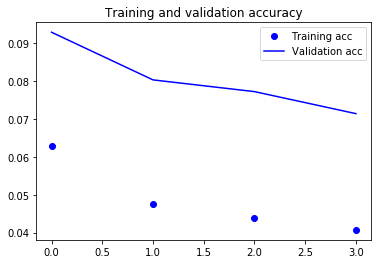

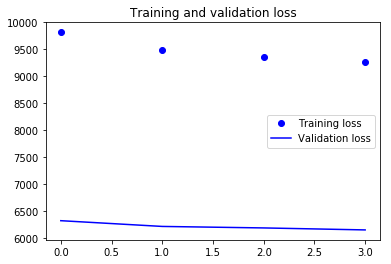

In [89]:
import matplotlib.pyplot as plt

acc = depth_history.history['acc']
val_acc = depth_history.history['val_acc']
loss = depth_history.history['loss']
val_loss = depth_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Визуализация предсказаний depth-сети

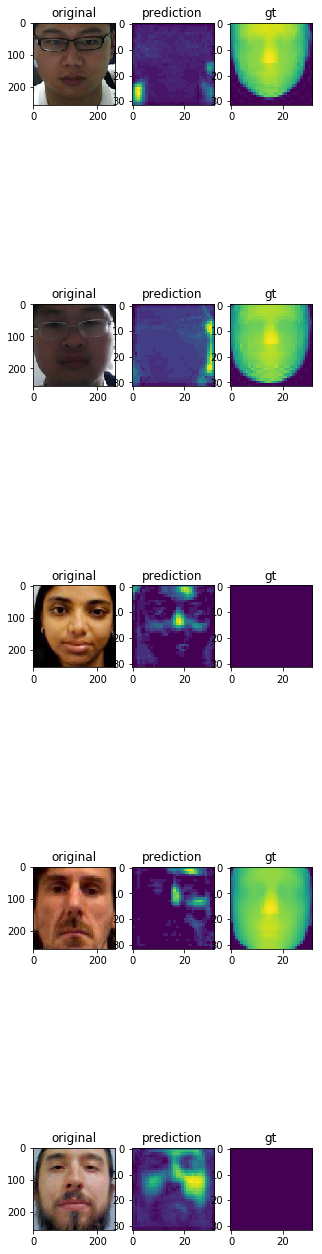

In [90]:
N_SHOW = 5
select_indices = np.random.choice(range(test_arrays.shape[0]), size=N_SHOW, replace=False)
plt.figure(figsize=(5, 5* 5))
for c,ind in enumerate(select_indices):
    if c == 0:
        plt.subplot(N_SHOW,3,c*2+1)
        plt.title('original')
        plt.imshow(test_arrays[ind])
        plt.subplot(N_SHOW,3,c*2+2)
        plt.title('prediction')
        image = model_for_depth.predict(np.expand_dims(test_arrays[ind], axis = 0))#[:,:,1])
        plt.imshow(image.astype(int)[0][:,:,0])
        plt.subplot(N_SHOW,3,c*2+3)
        plt.title('gt')
        plt.imshow(test_targets[ind][:,:,0])
    else:
        plt.subplot(N_SHOW,3,c*3+1)
        plt.title('original')
        plt.imshow(test_arrays[ind])
        plt.subplot(N_SHOW,3,c*3+2)
        plt.title('prediction')
        image = model_for_depth.predict(np.expand_dims(test_arrays[ind], axis = 0))#[:,:,1])
        plt.imshow(image.astype(int)[0][:,:,0])
        plt.subplot(N_SHOW,3,c*3+3)
        plt.title('gt')
        plt.imshow(test_targets[ind][:,:,0])
plt.show()

#### Загрузка архитектуры depth-сети

In [91]:
from keras.models import model_from_json
# Загружаем данные об архитектуре сети из файла json
json_file = open("weights_for_depth.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель на основе загруженных данных
loaded_model_for_depth = model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model_for_depth.load_weights("weights_for_depth.h5")

In [92]:
loaded_model_for_depth

In [93]:
len(loaded_model_for_depth.layers)

32

# Сеть для идентификации features

In [97]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model
import keras

from keras import layers 
from keras import Input 
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam, RMSprop, Adadelta

digit_input = Input(shape=(input_width, input_height, 3), dtype ='float32', name = 'feature_mapping')

dropout = 0.5 

x = layers.Conv2D(filters = 64, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(digit_input)
#x = layers.Dropout(dropout)(x)
x = layers.BatchNormalization()(x)

y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(x)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters= 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.MaxPooling2D((2, 2))(y)


z = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 196, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)                                                                             
z = layers.MaxPooling2D((2, 2))(z)

m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.MaxPooling2D((2, 2))(m)


# residual_1 = layers.Cropping2D(4, input_shape = (64,64,128))(y)
# residual_2 = layers.Cropping2D(2, input_shape = (32,32,128))(z)

# model.add(Cropping2D(cropping=((2, 2), (2, 2)), input_sh))
residual_2 = layers.Conv2D(128, 1, strides = 4, padding = 'same')(y)
residual_2 = layers.Dropout(dropout)(residual_2)
residual_1 = layers.Conv2D(128, 1, strides = 2, padding = 'same')(z)
residual_1 = layers.Dropout(dropout)(residual_1)


n = layers.add([residual_2, residual_1, m])

n = layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='elu', padding = 'same')(n)  
#n = layers.Dropout(dropout)(n)

n = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='elu', padding = 'same')(n) 
#n = layers.Dropout(dropout)(n)
n = layers.Conv2D(1, (1,1), activation = 'relu', padding = 'same')(n)
#n = layers.Dropout(dropout)(n)

n = layers.Flatten()(n)#(1, (1,1), activation = 'relu', padding = 'same')(n)

n = layers.Dense(32, activation = 'relu')(n)
#n = layers.Dense(1, (1,1), activation = 'relu', padding = 'same')(n)

n = layers.Dense(2, activation = 'softmax')(n)



model_for_feature = Model(digit_input, n)

# For a mean squared error regression problem
optimizer = Adam(lr= 0.0001, decay=0.8)

#model_for_feature.compile(optimizer, loss = 'mse')
model_for_feature.compile(optimizer, loss = 'mse', metrics=['accuracy', 'mse'])
model_for_feature.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_mapping (InputLayer)    (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 64) 1792        feature_mapping[0][0]            
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 256, 256, 64) 256         conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 256, 256, 128 73856       batch_normalization_21[0][0]     
__________________________________________________________________________________________________
batch_norm

In [98]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler= [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]


checkpoint = ModelCheckpoint(filepath='./weights_for_features.h5', verbose=1, save_best_only=True, save_weights_only=True)
# import tensorflow as tf
# with tf.device("device:GPU:1"):
earlyStopping = EarlyStopping(monitor='val_loss',
                                      patience=20, 
                                      verbose=1, mode='auto',min_delta = 0.5)

callbacks_list = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10)

#### Обучение feature-модели с early_stopping

In [ ]:
feature_history = model_for_feature.fit(train_arrays, train_labels,
                    epochs=15,
                    batch_size=5,
                    validation_data=(test_arrays, test_labels), callbacks = [checkpoint, earlyStopping, callbacks_list,  keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]) #earlyStopping

Train on 6000 samples, validate on 600 samples
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
6000/6000 [==============================] - 598s 100ms/step - loss: 0.2481 - acc: 0.5675 - mean_squared_error: 0.2481 - val_loss: 0.2374 - val_acc: 0.5617 - val_mean_squared_error: 0.2374

Epoch 00001: val_loss improved from 0.23788 to 0.23735, saving model to ./weights_for_features.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
6000/6000 [==============================] - 568s 95ms/step - loss: 0.2489 - acc: 0.5642 - mean_squared_error: 0.2489 - val_loss: 0.2367 - val_acc: 0.5650 - val_mean_squared_error: 0.2367

Epoch 00002: val_loss improved from 0.23735 to 0.23671, saving model to ./weights_for_features.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
6000/6000 [==============================] - 593s 99ms/step - loss: 0.2501 - acc: 0.5673 - me

In [44]:
feature_history = model_for_feature.fit(test_arrays, test_labels,
                    epochs=30, 
                    batch_size=5,
                    validation_data=(train_arrays, train_labels), callbacks = [checkpoint, earlyStopping, callbacks_list,  keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]) #earlyStopping

Train on 20 samples, validate on 20 samples
Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
20/20 [==============================] - 2s 125ms/step - loss: 0.1026 - val_loss: 0.2438

Epoch 00001: val_loss did not improve from 0.22668
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
20/20 [==============================] - 3s 125ms/step - loss: 0.0913 - val_loss: 0.2435

Epoch 00002: val_loss did not improve from 0.22668
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
20/20 [==============================] - 2s 124ms/step - loss: 0.1572 - val_loss: 0.2435

Epoch 00003: val_loss did not improve from 0.22668
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
20/20 [==============================] - 2s 124ms/step - loss: 0.0812 - val_loss: 0.2433

Epoch 00004: val_loss did not improve from 0.22668
Epoch 5/30



##### Сохранение архитектуры feature-сети

In [100]:
model_json = model_for_feature.to_json()
# Записываем модель в файл
json_file = open("model_for_feature.json", "w")
json_file.write(model_json)
json_file.close()

In [101]:
model_for_feature.save_weights("model_for_feature.h5")

### Отображение training и validation accuracy, training и validation loss для feature-сети

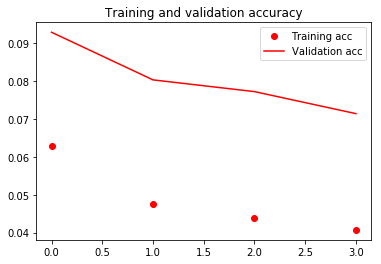

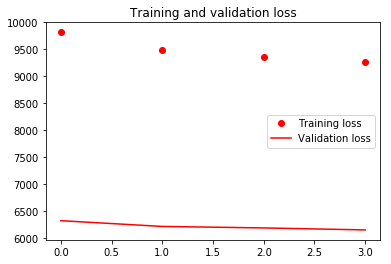

In [102]:
import matplotlib.pyplot as plt

acc = depth_history.history['acc']
val_acc = depth_history.history['val_acc']
loss = depth_history.history['loss']
val_loss = depth_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### Загрузка архитектуры feature-сети


In [146]:
from keras.models import model_from_json
# Загружаем данные об архитектуре сети из файла json
json_file = open("model_for_feature.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель на основе загруженных данных
loaded_model_for_feature = model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model_for_feature.load_weights("model_for_feature.h5")

In [147]:
loaded_model_for_feature

In [148]:
len(loaded_model_for_feature.layers)

35

### Визуализация предсказаний feature-сети (feature map промежуточных слоёв)

In [149]:
from keras import models
# извлечение вывода верхних 35 слоёв
model_for_feature
#layer_outputs = [layer.output for layer in model_for_feature.layers[:len(model_for_feature.layers)]]

layer_outputs = [layer.output for layer in loaded_model_for_feature.layers[:len(loaded_model_for_feature.layers)]]

#### Cлои в feature-сети

In [150]:
layer_outputs

[<tf.Tensor 'feature_mapping_2:0' shape=(?, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'conv2d_31_1/Elu:0' shape=(?, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_21_1/cond/Merge:0' shape=(?, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'conv2d_32_1/Elu:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_22_1/cond/Merge:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'conv2d_33_1/Elu:0' shape=(?, 256, 256, 196) dtype=float32>,
 <tf.Tensor 'batch_normalization_23_1/cond/Merge:0' shape=(?, 256, 256, 196) dtype=float32>,
 <tf.Tensor 'conv2d_34_1/Elu:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_24_1/cond/Merge:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_7_1/MaxPool:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'conv2d_35_1/Elu:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_25_1/cond/Merge:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'con

#### Извлечение имён слоёв в feature-сети

In [151]:
layer_names = []
for layer in loaded_model_for_feature.layers:
    layer_names.append(layer.name)

# layer_names = []
# for layer in model_for_feature.layers:
#     layer_names.append(layer.name)

In [152]:
layer_names

['feature_mapping',
 'conv2d_31',
 'batch_normalization_21',
 'conv2d_32',
 'batch_normalization_22',
 'conv2d_33',
 'batch_normalization_23',
 'conv2d_34',
 'batch_normalization_24',
 'max_pooling2d_7',
 'conv2d_35',
 'batch_normalization_25',
 'conv2d_36',
 'batch_normalization_26',
 'conv2d_37',
 'batch_normalization_27',
 'max_pooling2d_8',
 'conv2d_38',
 'batch_normalization_28',
 'conv2d_39',
 'batch_normalization_29',
 'conv2d_40',
 'conv2d_41',
 'conv2d_42',
 'batch_normalization_30',
 'dropout_5',
 'dropout_6',
 'max_pooling2d_9',
 'add_3',
 'conv2d_43',
 'conv2d_44',
 'conv2d_45',
 'flatten_2',
 'dense_3',
 'dense_4']

#### Активации всех слоёв feature-сети

In [153]:
from keras import models
activation_of_intermediate_layers = []
for element in list(range(len(layer_outputs))):#-4)):
    activation_model = models.Model(inputs=layer_outputs[0], outputs=layer_outputs[element])
    activation_of_intermediate_layers.append(activation_model)

In [154]:
activation_of_intermediate_layers

##### Предсказания указанного слоя на произвольном изображении

In [353]:
# # изображение из папки train
# import matplotlib.pyplot as plt
# indx = -1
# if train_labels[indx][0]==1:
#     plt.title('spoof')
# else:
#     plt.title('not_spoof')
# plt.imshow(test_arrays[indx])

In [321]:
# метка тестового изображения из папки  train
train_labels[indx][0]
im = train_arrays[indx]

#### Проверка на spoof-изображении

In [334]:
import cv2
import glob
#img = 'C:/Users/Maria/Desktop/crop_0019_01_05_05_1751.jpg'
img = 'C:/Users/Maria/Desktop/crop_0019_01_05_05_1910.jpg'#crop_0019_01_05_05_1898.jpg'
img = Image.open(img)

In [335]:
img000 = img.resize((input_width,input_height))

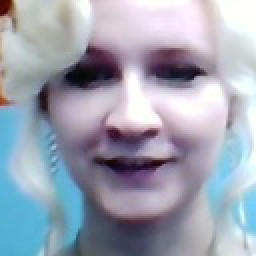

In [336]:
img000

In [329]:
#препроцессинг тестового изображения из папки  train
from keras.preprocessing import image 
img_tensor = image.img_to_array(img000)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /=255.

In [330]:
test_predict = model_for_feature.predict(img_tensor)

In [337]:
test_predict

array([[0.8482509 , 0.15174906]], dtype=float32)

#### Проверка на не spoof-изображении

In [342]:
import cv2
import glob
#img = 'C:/Users/Maria/Desktop/crop_0019_01_05_05_1751.jpg'
img = 'C:/Users/Maria/Desktop/crop_0019_01_05_03_273.jpg'#crop_0019_01_05_05_1898.jpg'
img = Image.open(img)

In [345]:
img111 = img.resize((input_width,input_height))

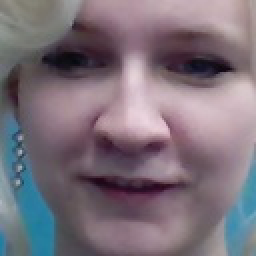

In [347]:
img111

In [349]:
#препроцессинг тестового изображения из папки  train
from keras.preprocessing import image 
img_tensor = image.img_to_array(img111)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /=255.

In [351]:
test_predict = model_for_feature.predict(img_tensor)

In [352]:
test_predict

array([[0.1884068 , 0.81159323]], dtype=float32)

#### Слой, с которого снимается feature map

In [192]:
layer_names[len(layer_outputs)-4]

'conv2d_45'

#### Предсказания на указанном слое

In [193]:
activations = activation_of_intermediate_layers[len(layer_outputs)-4].predict(img_tensor)

In [194]:
activations

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)

In [195]:
activations.shape

(1, 32, 32, 1)

In [196]:
train_arrays[0].shape

(256, 256, 3)

In [197]:
img_tensor.shape

(1, 256, 256, 3)

###### Визуализация 0-ого канала заданного ранее слоя


In [198]:
activations = activations.flatten().reshape(32, 32, 1)

In [199]:
activations.shape

(32, 32, 1)

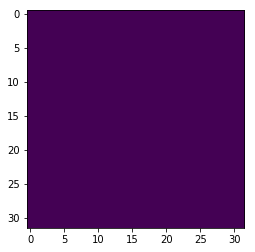

In [200]:
plt.imshow(activations[:,:,0])
plt.show()

# Non-rigid Registration Layer

###### Исходное изображение

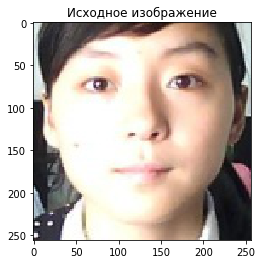

In [236]:
indx = 2
plt.title('Исходное изображение')
plt.imshow(test_arrays[indx])

In [237]:
test_predict = model_for_depth.predict(np.expand_dims(test_arrays[14], axis = 0)).astype(int)[0][:,:,0]

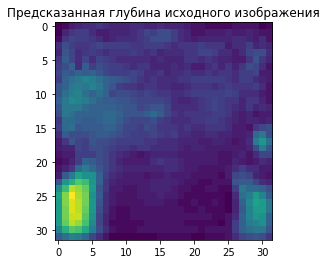

In [238]:
plt.title('Предсказанная глубина исходного изображения')
plt.imshow(test_predict)

In [239]:
test_predict.shape

(32, 32)

##### Генерация бинарной маски по threshold карты глубины (threshold = 0.1)

In [240]:
# схлопывание изображения 32 на 32
flattened_test_predict = test_predict.ravel()

In [241]:
threshold = 0.1

In [242]:
# Zero values below "threshold value".
#зануление тех элементов массива, значения которых не удовлетворяют условию
def flat_values(sig, tv):
    """
    :param sig: signal.
    :param tv: threshold value.
    :return:
    """
    for i in np.arange(np.size(sig)):
        if sig[i] < tv:
            sig[i] = 0
    return sig

In [243]:
binary_test_predict = flat_values(flattened_test_predict, threshold)

In [244]:
binary_test_predict.shape

(1024,)

In [245]:
# изменение формы массива
binary_test_predict = binary_test_predict.reshape((32, 32))

In [246]:
binary_test_predict.shape

(32, 32)

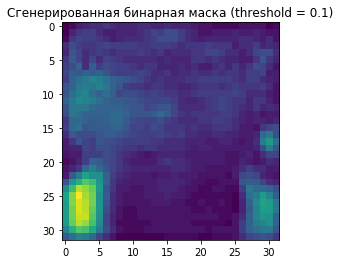

In [247]:
plt.title('Сгенерированная бинарная маска (threshold = 0.1)')
plt.imshow(binary_test_predict)

## Скалярное произведение (inner product) предсказаний depth-сети и feature-сети


In [248]:
binary_test_predict_for_inner_product_vector = binary_test_predict.ravel()

In [249]:
binary_test_predict_for_inner_product_vector.shape

(1024,)

In [250]:
#препроцессинг тестового изображения из папки  train
from keras.preprocessing import image 
img_tensor = image.img_to_array(test_arrays[14])
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /=255.

In [251]:
activations = activation_of_intermediate_layers[len(layer_outputs)-4].predict(img_tensor)

In [252]:
# скалярное произведение векторов
def native_vector_dot(x, y):
    #проверка на то, что x и y - вектора
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z+= x[i]*y[i]
    return z

In [253]:
#скалярное произведение матриц
def native_matrix_dot(x, y):
    #проверка на то, что x и y - матрицы Numpy
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1]))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i,j]= native_vector_dot(row_x, column_y)
    return z

##### Форма feature-предсказания

In [254]:
activations.shape

(1, 32, 32, 1)

In [255]:
#изменение формы тензора для выполнения операции скалярного умножения

In [256]:
activations_1 = activations.flatten().reshape(32, 32)

In [257]:
activations_1.shape

(32, 32)

In [258]:
binary_test_predict.shape

(32, 32)

### Скалярное произведение (inner product) бинарной маски и feature map


In [259]:
inner_product = native_matrix_dot(activations_1, binary_test_predict)

In [264]:
inner_product.min()

0.0

In [261]:
inner_product.shape

(32, 32)

In [229]:
inner_product_1 = inner_product.flatten().reshape(32, 32, 1)

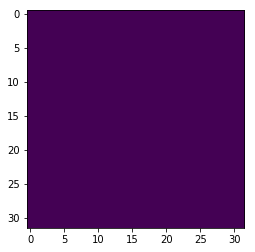

In [284]:
plt.imshow(inner_product_1[:,:,0])
plt.show()

In [287]:
layer_outputs

[<tf.Tensor 'feature_mapping_2:0' shape=(?, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'conv2d_31_1/Elu:0' shape=(?, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_21_1/cond/Merge:0' shape=(?, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'conv2d_32_1/Elu:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_22_1/cond/Merge:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'conv2d_33_1/Elu:0' shape=(?, 256, 256, 196) dtype=float32>,
 <tf.Tensor 'batch_normalization_23_1/cond/Merge:0' shape=(?, 256, 256, 196) dtype=float32>,
 <tf.Tensor 'conv2d_34_1/Elu:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_24_1/cond/Merge:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_7_1/MaxPool:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'conv2d_35_1/Elu:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_25_1/cond/Merge:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'con

In [296]:
activations = activation_of_intermediate_layers[len(layer_outputs)-5].predict(img_tensor)

In [295]:
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_for_another_layer):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[-1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[:, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()
           

MemoryError: 

In [45]:
img_path = 'C:/Users/Maria/Desktop/Spoofing_detection/New_Dataset/train/photos/spoof/crop_0001_00_00_01_148.jpg'
from keras.preprocessing import image 
img = image.load_img(img_path, target_size =(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /=255.

##### Оригинальное изображение spoof

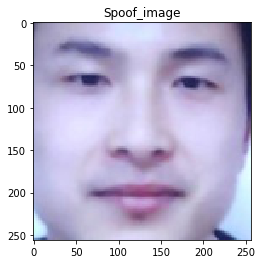

In [46]:
if img_path.find(str('spoof'))!= -1:
    plt.title('Spoof_image')
else: 
    plt.title('Not_spoof_image')

plt.imshow(img_tensor[0])
plt.show()

In [51]:
image = model_for_depth.predict(img_tensor)

In [52]:
image = loaded_model_for_depth.predict(img_tensor)

In [53]:
img_tensor.shape

(1, 256, 256, 3)

In [54]:
image.shape

(1, 32, 32, 1)

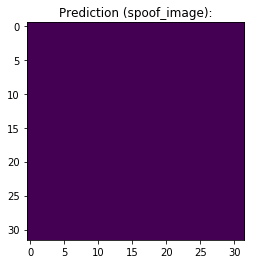

In [55]:
if img_path.find(str('spoof'))!= -1:
    plt.title('Prediction (spoof_image):')
else: 
    plt.title('Prediction (not_spoof_image)')
plt.imshow(image.astype(int)[0][:,:,0])
plt.show()

### Сеть для идентификации features

In [30]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model
import keras

from keras import layers 
from keras import Input 
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam, RMSprop, Adadelta

digit_input = Input(shape=(input_width, input_height, 3), dtype ='float32', name = 'feature_mapping')

dropout = 0.5 

x = layers.Conv2D(filters = 64, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(digit_input)
#x = layers.Dropout(dropout)(x)
x = layers.BatchNormalization()(x)

y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(x)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters= 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.MaxPooling2D((2, 2))(y)


z = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 196, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)                                                                             
z = layers.MaxPooling2D((2, 2))(z)

m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.MaxPooling2D((2, 2))(m)


# residual_1 = layers.Cropping2D(4, input_shape = (64,64,128))(y)
# residual_2 = layers.Cropping2D(2, input_shape = (32,32,128))(z)

# model.add(Cropping2D(cropping=((2, 2), (2, 2)), input_sh))
residual_2 = layers.Conv2D(128, 1, strides = 4, padding = 'same')(y)
residual_2 = layers.Dropout(dropout)(residual_2)
residual_1 = layers.Conv2D(128, 1, strides = 2, padding = 'same')(z)
residual_1 = layers.Dropout(dropout)(residual_1)


n = layers.add([residual_2, residual_1, m])

n = layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='elu', padding = 'same')(n)  
#n = layers.Dropout(dropout)(n)

n = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='elu', padding = 'same')(n) 
#n = layers.Dropout(dropout)(n)
n = layers.Conv2D(1, (1,1), activation = 'relu', padding = 'same')(n)
#n = layers.Dropout(dropout)(n)

n = layers.Flatten()(n)#(1, (1,1), activation = 'relu', padding = 'same')(n)

n = layers.Dense(32, activation = 'relu')(n)
#n = layers.Dense(1, (1,1), activation = 'relu', padding = 'same')(n)

n = layers.Dense(2, activation = 'softmax')(n)



model_for_feature = Model(digit_input, n)

# For a mean squared error regression problem
optimizer = Adam(lr= 0.0001, decay=0.8)

model_for_feature.compile(optimizer, loss = 'mse')
model_for_feature.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_mapping (InputLayer)    (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 64) 1792        feature_mapping[0][0]            
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 256, 256, 64) 256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 128 73856       batch_normalization_11[0][0]     
____________________________________________________________________________________________

In [32]:
feature_history = model_for_feature.fit(train_arrays, train_labels,  batch_size=5, epochs=20, validation_split=0.2) #earlyStopping

Train on 1920 samples, validate on 480 samples
Epoch 1/20
1920/1920 [==============================] - 191s 100ms/step - loss: 0.2686 - val_loss: 0.4363
Epoch 2/20
1920/1920 [==============================] - 192s 100ms/step - loss: 0.2679 - val_loss: 0.4096
Epoch 3/20
1920/1920 [==============================] - 192s 100ms/step - loss: 0.2606 - val_loss: 0.4046
Epoch 4/20
1920/1920 [==============================] - 196s 102ms/step - loss: 0.2592 - val_loss: 0.3970
Epoch 5/20
1920/1920 [==============================] - 200s 104ms/step - loss: 0.2542 - val_loss: 0.3913
Epoch 6/20
1920/1920 [==============================] - 197s 102ms/step - loss: 0.2576 - val_loss: 0.3855
Epoch 7/20
1920/1920 [==============================] - 198s 103ms/step - loss: 0.2553 - val_loss: 0.3844
Epoch 8/20
1920/1920 [==============================] - 200s 104ms/step - loss: 0.2589 - val_loss: 0.3806
Epoch 9/20
1920/1920 [==============================] - 201s 105ms/step - loss: 0.2594 - val_loss: 0.3779

#### Сохранение архитектуры feature-сети

In [39]:
model_json = model_for_feature.to_json()
# Записываем модель в файл
json_file = open("model_for_feature.json", "w")
json_file.write(model_json)
json_file.close()

In [40]:
model_for_feature.save_weights("model_for_feature.h5")

##### Загрузка архитектуры feature-сети

In [41]:
from keras.models import model_from_json
# Загружаем данные об архитектуре сети из файла json
json_file = open("model_for_feature.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель на основе загруженных данных
loaded_model_for_feature = model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model_for_feature.load_weights("model_for_feature.h5")

In [42]:
loaded_model_for_feature

#### Тестирование на изображении 

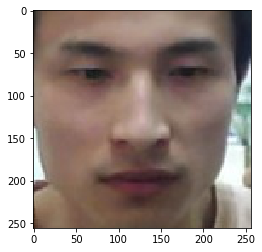

In [43]:
import matplotlib.pyplot as plt 
plt.imshow(train_arrays[0])

In [44]:
train_labels[0]

array([0., 1.], dtype=float32)

In [45]:
from keras.preprocessing import image 
img_tensor = image.img_to_array(train_arrays[0])
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /=255.

In [46]:
img_tensor.shape

(1, 256, 256, 3)

In [47]:
len(loaded_model_for_feature.layers)

35

# Визуализация feature map промежуточных слоёв

In [48]:
from keras import models
# извлечение вывода верхних 35 слоёв
layer_outputs = [layer.output for layer in loaded_model_for_feature.layers[:len(loaded_model_for_feature.layers)]]

In [49]:
layer_outputs

[<tf.Tensor 'feature_mapping_1:0' shape=(?, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'conv2d_16_1/Elu:0' shape=(?, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_11_1/cond/Merge:0' shape=(?, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'conv2d_17_1/Elu:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_12_1/cond/Merge:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'conv2d_18_1/Elu:0' shape=(?, 256, 256, 196) dtype=float32>,
 <tf.Tensor 'batch_normalization_13_1/cond/Merge:0' shape=(?, 256, 256, 196) dtype=float32>,
 <tf.Tensor 'conv2d_19_1/Elu:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_14_1/cond/Merge:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4_1/MaxPool:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'conv2d_20_1/Elu:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_15_1/cond/Merge:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'con

#### Извлечение имен слоёв

In [50]:
layer_names = []
for layer in loaded_model_for_feature.layers:
    layer_names.append(layer.name)

In [51]:
layer_names

['feature_mapping',
 'conv2d_16',
 'batch_normalization_11',
 'conv2d_17',
 'batch_normalization_12',
 'conv2d_18',
 'batch_normalization_13',
 'conv2d_19',
 'batch_normalization_14',
 'max_pooling2d_4',
 'conv2d_20',
 'batch_normalization_15',
 'conv2d_21',
 'batch_normalization_16',
 'conv2d_22',
 'batch_normalization_17',
 'max_pooling2d_5',
 'conv2d_23',
 'batch_normalization_18',
 'conv2d_24',
 'batch_normalization_19',
 'conv2d_25',
 'conv2d_26',
 'conv2d_27',
 'batch_normalization_20',
 'dropout_3',
 'dropout_4',
 'max_pooling2d_6',
 'add_2',
 'conv2d_28',
 'conv2d_29',
 'conv2d_30',
 'flatten_1',
 'dense_1',
 'dense_2']

In [60]:
from keras import models
activation_of_intermediate_layers = []
for element in list(range(len(layer_outputs))):#-4)):
    activation_model = models.Model(inputs=layer_outputs[0], outputs=layer_outputs[element])
    activation_of_intermediate_layers.append(activation_model)

In [61]:
activation_of_intermediate_layers

In [96]:
layer_names[len(layer_outputs)-6]

'conv2d_28'

In [97]:
activations = activation_of_intermediate_layers[len(layer_outputs)-6].predict(img_tensor)

In [98]:
activations

array([[[[ 4.52942967e-01, -9.11005020e-01,  1.42514491e+00, ...,
          -8.13969016e-01, -5.98505378e-01,  2.14224052e+00],
         [-7.99138546e-01, -6.99741602e-01, -2.32663929e-01, ...,
          -4.40849841e-01, -9.15080309e-03,  1.48143038e-01],
         [-6.87865496e-01, -7.70764470e-01,  1.23419821e+00, ...,
          -8.46627474e-01, -7.31404006e-01, -7.92048097e-01],
         ...,
         [-4.74932551e-01, -8.90906394e-01,  9.11794722e-01, ...,
          -8.33042026e-01, -8.55593681e-01, -5.89567125e-01],
         [-1.49791539e-01, -7.38190830e-01,  2.51598537e-01, ...,
          -8.36895585e-01, -8.47862542e-01, -5.26914179e-01],
         [ 1.30689669e+00, -8.66370738e-01,  1.46176779e+00, ...,
           7.52977729e-01, -4.02631819e-01, -2.35744417e-01]],

        [[-8.11512828e-01, -5.50666571e-01, -6.60844684e-01, ...,
          -7.36950278e-01, -8.97671461e-01,  9.21804547e-01],
         [-9.92137909e-01, -3.41172218e-01, -3.19517314e-01, ...,
           1.50930595e

In [99]:
activations.shape

(1, 32, 32, 128)

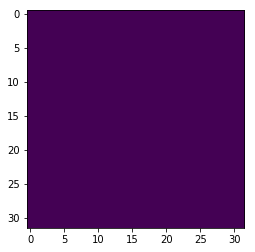

In [100]:
plt.imshow(activations.astype(int)[0][:,:,11])
plt.show()

In [101]:
activations = activations.astype(int)[0][:,:,11]


In [107]:
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            #activations.astype(int)[0][:,:,0]
            channel_image = layer_activation.astype(int)[0, :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

IndexError: tuple index out of range

In [ ]:
activations = activation_of_intermediate_layers[0].predict(img_tensor)

In [ ]:
len(aaa)

In [ ]:
type(activations)

In [ ]:
len(layer_outputs)

In [ ]:
len(activations)

In [ ]:
activations.shape

In [ ]:
first_layer_activation = activations[0]

In [ ]:
first_layer_activation.shape

In [ ]:
activations.shape

In [ ]:
len(activations)

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow()

In [ ]:
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            #activations.astype(int)[0][:,:,0]
            channel_image = layer_activation.astype(int)[:, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[:, :, 10], cmap = 'viridis')

In [ ]:
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[-1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[:, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()


In [ ]:
prediction = loaded_model_for_feature.predict(img_tensor)

In [ ]:
prediction

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
activations

In [ ]:
len(activations)

In [ ]:
first_layer_activation.shape

In [ ]:
first_layer_activation.shape

In [ ]:
#активация первого свёрточного слоя для входного тестового изображения
first_layer_activation = activations[0]
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[0,:, :, 0], cmap = 'viridis')

In [ ]:
# import keras

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model.layers[:8]:
#     layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[:, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras import layers 
from keras import Input 
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam, RMSprop, Adadelta

### Определение свёрточной сети с полносвязанным слоем на выходе

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model
import keras

from keras import layers 
from keras import Input 
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam, RMSprop, Adadelta

digit_input = Input(shape=(input_width, input_height, 3), dtype ='float32', name = 'depth_mapping')

dropout = 0.5 

x = layers.Conv2D(filters = 64, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(digit_input)
#x = layers.Dropout(dropout)(x)
x = layers.BatchNormalization()(x)

y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(x)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters= 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#y = layers.Dropout(dropout)(y)
y = layers.BatchNormalization()(y)
y = layers.MaxPooling2D((2, 2))(y)


z = layers.Conv2D(filters = 128, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(y)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 196, kernel_size = (3, 3),strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)
z = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#z = layers.Dropout(dropout)(z)
z = layers.BatchNormalization()(z)                                                                             
z = layers.MaxPooling2D((2, 2))(z)

m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(z)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 196, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides=(1,1), activation='elu', padding = 'same')(m)
#m = layers.Dropout(dropout)(m)
m = layers.BatchNormalization()(m)
m = layers.MaxPooling2D((2, 2))(m)


# residual_1 = layers.Cropping2D(4, input_shape = (64,64,128))(y)
# residual_2 = layers.Cropping2D(2, input_shape = (32,32,128))(z)

# model.add(Cropping2D(cropping=((2, 2), (2, 2)), input_sh))
residual_2 = layers.Conv2D(128, 1, strides = 4, padding = 'same')(y)
residual_2 = layers.Dropout(dropout)(residual_2)
residual_1 = layers.Conv2D(128, 1, strides = 2, padding = 'same')(z)
residual_1 = layers.Dropout(dropout)(residual_1)


n = layers.add([residual_2, residual_1, m])

n = layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='elu', padding = 'same')(n)  
#n = layers.Dropout(dropout)(n)

n = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='elu', padding = 'same')(n) 
#n = layers.Dropout(dropout)(n)
n = layers.Conv2D(1, (1,1), activation = 'relu', padding = 'same')(n)
#n = layers.Dropout(dropout)(n)

n = layers.Flatten()(n)#(1, (1,1), activation = 'relu', padding = 'same')(n)

n = layers.Dense(32, activation = 'relu')(n)
#n = layers.Dense(1, (1,1), activation = 'relu', padding = 'same')(n)

n = layers.Dense(2, activation = 'softmax')(n)



model = Model(digit_input, n)

# For a mean squared error regression problem
optimizer = Adam(lr= 0.0001, decay=0.8)

model.compile(optimizer, loss = 'mse')
model.summary()

In [ ]:
history = model.fit(train_arrays, train_labels,  batch_size=8, epochs=2, validation_split=0.2) #earlyStopping

# Сохранение архитектуры сети

In [ ]:
model_json = model.to_json()
# Записываем модель в файл
json_file = open("model.json", "w")
json_file.write(model_json)
json_file.close()

In [ ]:
model.save_weights("model.h5")

# Загрузка обученной сети

In [ ]:
from keras.models import model_from_json

In [ ]:
# Загружаем данные об архитектуре сети из файла json
json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель на основе загруженных данных
loaded_model = model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model.load_weights("model.h5")

In [ ]:
loaded_model_json

##### обученная ранее сеть

In [ ]:
loaded_model

# тестирование на изображении

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(train_arrays[0])

In [ ]:
train_labels[0]

In [ ]:
depth_map

In [ ]:
train_arrays[3].resize((output_width, output_height)

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(train_arrays[3])

In [ ]:
img_path = '/home/akbds/notebooks/DataScienceTeam/Spoofing_detection/New_Dataset/train/photos/spoof/crop_0001_00_00_01_148.jpg'
from keras.preprocessing import image 
# img = image.load_img(img_path, target_size =(256, 256))
img_tensor = image.img_to_array(train_arrays[4])
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /=255.

In [ ]:
img_tensor.shape

In [ ]:
len(loaded_model.layers)

##### визуализация feature map промежуточных слоёв

In [ ]:
from keras import models
# извлечение вывода верхних 15 слоёв
layer_outputs = [layer.output for layer in loaded_model.layers[:35-4]]

In [ ]:
#извлечение имен слоёв
layer_names = []
input_layer = []
for layer in loaded_model.layers[:15]:
    layer_names.append(layer.name)
    input_layer.append(layer.input)

In [ ]:
layer_names

In [ ]:
input_layer

In [ ]:
k

###### k[0] - входной слой

In [ ]:
k[4]

##### layer_outputs[-1] - входной слой

In [ ]:
layer_outputs[-1]

In [ ]:
layer_outputs

In [ ]:
len(layer_outputs)

In [ ]:
activation_model = models.Model(inputs=k[0], outputs=layer_outputs[len(layer_outputs)-2])

In [ ]:
prediction = loaded_model.predict(img_tensor)

In [ ]:
prediction

In [ ]:
img_tensor.shape

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
activations

In [ ]:
len(activations)

In [ ]:
#активация первого свёрточного слоя для входного тестового изображения
first_layer_activation = activations[0]

In [ ]:
first_layer_activation.shape

In [ ]:
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[:, :, 0], cmap = 'viridis')

In [ ]:
# import keras

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model.layers[:8]:
#     layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[:, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
layer_names = []
k = []

In [ ]:
k[0]

In [ ]:
layer_outputs

In [ ]:
layer_outputs[-1]

In [ ]:
activation_model = models.Model(inputs=k[0], outputs=layer_outputs[-1])

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
k

In [ ]:
layer_names

In [ ]:
layer_outputs

In [ ]:
x

In [ ]:
digit_input

In [ ]:
img_tensor

In [ ]:
image = loaded_model.predict(img_tensor)

In [ ]:
image


In [ ]:
activation_model = models.Model(input=digit_input, outputs = layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor, steps =1)

In [ ]:
https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

In [ ]:
#test
POS_TEST_DIR = '/home/maria/Desktop/notebooks/DataScienceTeam/Spoofing_detection/New_Dataset/test/photos/spoof'
NEG_TEST_DIR = '/home/maria/Desktop/notebooks/DataScienceTeam/Spoofing_detection/New_Dataset/test/photos/not_spoof/'
LAB_TEST_DIR = '/home/maria/Desktop/notebooks/DataScienceTeam/Spoofing_detection/New_Dataset/test/labels/not_spoof/'

pos_test_images = os.listdir(POS_TEST_DIR)
neg_test_images = os.listdir(NEG_TEST_DIR)
neg_test_labels = os.listdir(LAB_TEST_DIR)

In [ ]:
#количество pos_images, neg_images, neg_labels в папке test 
len(pos_test_images), len(neg_test_images), len(neg_test_labels)

In [ ]:
#количество взятых изображений из папки test
N_TEST_IMG = 500
#вход и выход нейронной сети
input_width = input_height = 256
output_width = output_height = 32 

In [ ]:
select_test_labels = np.random.choice(neg_test_labels, size=N_TEST_IMG, replace=False)
select_test_pos = np.random.choice(pos_test_images, size=N_TEST_IMG, replace=False)

In [ ]:
test_arrays = []
test_targets = []
test_labels = []

for lab in select_test_labels:
    fp = os.path.join(LAB_TEST_DIR, lab)
    with open(fp, 'rb') as f:
        depth_map = pickle.load(f)
    depth_map = Image.fromarray(depth_map)
    depth_map = depth_map.resize((output_width, output_height))
    fp = os.path.join(NEG_TEST_DIR, lab[:-10] + '.jpg')
    img = Image.open(fp)
    img = img.resize((input_width,input_height))
    if img.size != (input_width,input_height):
        print(img.size)
    test_arrays.append(np.array(img))
    test_targets.append(np.array(depth_map))
    test_labels.append(1)


for pos in select_test_pos:
    fp = os.path.join(POS_TEST_DIR, pos)
    img = Image.open(fp)
    img = img.resize((input_width,input_height))
    if img.size != (input_width,input_height):
        print(img.size)
    test_arrays.append(np.array(img))
    test_targets.append(np.zeros((output_width, output_height), dtype=np.uint8))
    test_labels.append(0)

In [ ]:
from keras.utils import to_categorical
test_labels = to_categorical(test_labels)

In [ ]:
test_arrays = np.array(test_arrays)

In [ ]:
test_targets = np.reshape(np.array(test_targets), (N_IMG*2, output_width,output_height,1))

In [ ]:
test_arrays.shape

In [ ]:
test_targets.shape

In [ ]:
test_labels.shape

In [ ]:
test_arrays = test_arrays / 255.

In [ ]:
permute = np.random.permutation(range(test_arrays.shape[0]))
test_arrays = test_arrays[permute]
test_targets = test_targets[permute]
test_labels = test_labels[permute]

In [ ]:
N_SHOW = 5
select_indices = np.random.choice(range(test_arrays.shape[0]), size=N_SHOW, replace=False)

plt.figure(figsize=(10, N_SHOW * 5))

for c,ind in enumerate(select_indices):
    plt.subplot(N_SHOW,2,c*2+1)
    plt.imshow(test_arrays[ind])
    plt.subplot(N_SHOW,2,c*2+2)
    plt.imshow(test_targets[ind][:,:,0])
    
plt.show()